**Fronteiras Teóricas e mapa de regimes**

# Fig. 1 - Toeria (fronteiras) e mapa de regimes ($\mu$ x $ϵ$)

Objetivo: Reproduzir geometria teórica das fronteiras de **sincronização** e **escape** no plano ($\mu$, $ϵ$) - Figura 1 do artigo, cin:
- Fronteiras de **sincronização** (banda entre curvas),
- **Escape** (curvas tracejadas)
- Divisão entre região sincronizada caótica e estacionária

## Introdução e motivação

> Artigo: [arXiv:1402.4870](https://arxiv.org/pdf/1402.4870)

O objetivo do artigo é verificar o efeito de inserirmos uma **interação global** na evolução do sistema

Pense na seguinte analogia: 

Diferente do ising local que vimos ao longo do curso (troca de spin afetada apenas pelos primeiros vizinhos), queremos observar como o efeito de um spin sentir uma média global do sistema afeta sua evolução ao longo do tempo.

Uma boa analogia da vida real que poemos fazer é a seguinte: Imagine que estamos vendo opiniões/canais que cada casa escolhe ver em um páis. Além disso, existe um jornal global que diz a média de opiniões/canais de todo mundo. 

A opinião/canal assistido de cada casa é influenciada tanto pelos seus vizinhos quanto pela média global (opinião de todas as casas). 

A modelagem matemática feita pelo artigo e que iremos seguir ao longo do notebook é a seguinte

Consideramos **N** mapas acoplados globalmente:

$$\boxed{x_i^{t+1} = (1-\varepsilon)f(x_i^{t}, \mu) + \frac{\varepsilon}{N}\sum_{j=1}^{N} f(x_j^{t}, \mu),\quad i=1,\dots,N}$$

Imaginei que cada $x^{i}$ é um spin/ opinião de uma casa em específico e sua evolução é determinada por um mapa local $f(x_j, \mu)$ e uma média global, cuja influência é determinada pelo peso da variável $\varepsilon$.

Logo $\varepsilon$ mais próximo de 1, maior o peso da influência global (valores maiores fazem o mapa local ter mais influência).

Abaixo vamos entender o comportamento das fronteiras


## Imports, utilidades e paths

In [2]:
## Imports, utilidades e paths

import json,os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Usamos diretamente as funções do pacote
import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))
from gcm.maps import sync_boundaries, escape_boundaries

# Saídas
FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

# Domínio "igual ao artigo"
MU_MIN, MU_MAX = -3.0, 3.0
EPS_MIN, EPS_MAX = -1, 3    # faixa vertical ampla para visualizar tudo com conforto

mu_grid = np.linspace(MU_MIN, MU_MAX, 1201)

# Paleta (tons suaves para enxergar sobreposições)
COL_BG_NON_SYNC  = "#e09f3e"  # não sincronizado (Honey Bronze)
COL_SYNC_STAT    = "#335c67"  # síncrono estacionário (Dark Slate Grey)
COL_SYNC_CHAOS   = "#9fd356"  # síncrono caótico (Yellow Green)
COL_ESCAPE       = "#9e2a2b"  # escape (Brown Red)

# Cores das linhas
COL_SYNC_LINE    = "black"  # linhas de sincronização (verde-escuro)
COL_ESC_LINE     = "#b22222"  # linhas de escape (vermelho-escuro)

def arrays_from_boundaries(mu_vec):
    """Gera arrays (eps_sync_inf, eps_sync_sup, eps_esc_lo, eps_esc_hi) ao longo de mu_vec."""
    s_inf = np.empty_like(mu_vec, dtype=float)
    s_sup = np.empty_like(mu_vec, dtype=float)
    e_lo  = np.empty_like(mu_vec, dtype=float)
    e_hi  = np.empty_like(mu_vec, dtype=float)

    for i, mu in enumerate(mu_vec):
        if abs(mu) < 1e-12:
            s_inf[i] = np.nan; s_sup[i] = np.nan
            e_lo[i]  = np.nan; e_hi[i]  = np.nan
            continue
        si, ss = sync_boundaries(mu)      # usa gcm.maps
        el, eh = escape_boundaries(mu)    # usa gcm.maps
        s_inf[i], s_sup[i] = si, ss
        e_lo[i],  e_hi[i]  = el, eh
    return s_inf, s_sup, e_lo, e_hi


## Curvas teóricas com sombreamento por regiões

Figura salva em: figs/FIG1_mu_eps_teoria_annot.png


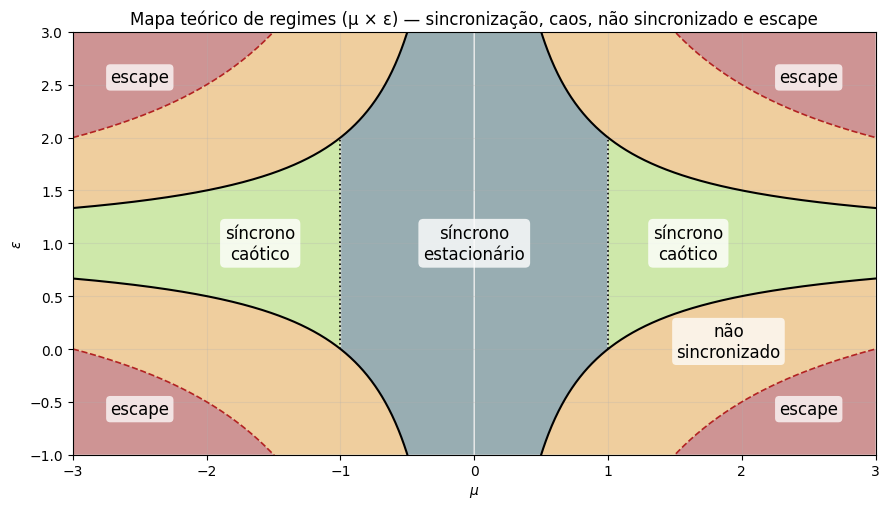

In [3]:
sync_inf, sync_sup, esc_lo, esc_hi = arrays_from_boundaries(mu_grid)

# Clipping para o retângulo de interesse (evita problemas de ±inf/NaN nos fills)
def clip(a): return np.clip(a, EPS_MIN, EPS_MAX)
c_sync_inf, c_sync_sup = clip(sync_inf), clip(sync_sup)
c_esc_lo,  c_esc_hi    = clip(esc_lo),  clip(esc_hi)

valid_sync = np.isfinite(sync_inf) & np.isfinite(sync_sup)
valid_esc  = np.isfinite(esc_lo)  & np.isfinite(esc_hi)

mask_stat  = (np.abs(mu_grid) <  1.0)
mask_chaos = (np.abs(mu_grid) >= 1.0)

fig, ax = plt.subplots(figsize=(9, 5.2))
ax.set_facecolor("#FFFFFF")

# --- ESCAPE (vermelho-claro), acima e abaixo das curvas tracejadas ---
# abaixo
ax.fill_between(mu_grid, EPS_MIN, c_esc_lo, where=valid_esc, color=COL_ESCAPE, alpha=0.5, linewidth=0)
# acima
ax.fill_between(mu_grid, c_esc_hi, EPS_MAX, where=valid_esc, color=COL_ESCAPE, alpha=0.5, linewidth=0)


# ---------------- NÃO SINCRONIZADO ---------------- #
# Definição: entre ESCAPE e a banda de SINCRONIZAÇÃO
# parte inferior: esc_lo → sync_inf
mask_ns_lower = valid_esc & valid_sync & (c_esc_lo < c_sync_inf)
ax.fill_between(
    mu_grid, c_esc_lo, c_sync_inf,
    where=mask_ns_lower, color=COL_BG_NON_SYNC, alpha=0.5, linewidth=0,)
# parte superior: sync_sup → esc_hi
mask_ns_upper = valid_esc & valid_sync & (c_sync_sup < c_esc_hi)
ax.fill_between(
    mu_grid, c_sync_sup, c_esc_hi,
    where=mask_ns_upper, color=COL_BG_NON_SYNC, alpha=0.5, linewidth=0)


# --- REGIÃO SINCRONIZADA ---
# Síncrono estacionário: |μ|<1  
ax.fill_between(mu_grid, c_sync_inf, c_sync_sup,
                where=valid_sync & mask_stat,
                color=COL_SYNC_STAT, alpha=0.5, linewidth=0)
# Síncrono caótico: |μ|≥1  
ax.fill_between(mu_grid, c_sync_inf, c_sync_sup,
                where=valid_sync & mask_chaos,
                color=COL_SYNC_CHAOS, alpha=0.5, linewidth=0)

# --- LINHAS DE REFERÊNCIA ---
# Fronteiras de sincronização (sólidas)
ax.plot(mu_grid, sync_inf, color=COL_SYNC_LINE, lw=1.5)
ax.plot(mu_grid, sync_sup, color=COL_SYNC_LINE, lw=1.5)

# Fronteiras de escape (tracejadas, vermelho-escuro)
ax.plot(mu_grid, esc_lo, color=COL_ESC_LINE, lw=1.2, ls="--")
ax.plot(mu_grid, esc_hi, color=COL_ESC_LINE, lw=1.2, ls="--")

# Linhas verticais μ = -1 e μ = 1 (pontilhadas, pretas finas)
def vsegment_inside_sync(mu0: float):
    si, ss = sync_boundaries(mu0)
    if not (np.isfinite(si) and np.isfinite(ss)):
        return
    si, ss = float(clip(si)), float(clip(ss))
    if si < ss:  # só plota se fizer sentido
        ax.plot([mu0, mu0], [si, ss], color="k", lw=1.2, ls=":", zorder=5)

vsegment_inside_sync(-1.0)
vsegment_inside_sync( 1.0)


# --- RÓTULOS DENTRO DAS REGIÕES (sem legenda externa) ---
# posições "inteligentes" (escolhidas para evitar sobreposição)
def mid_sync(mu):
    si, ss = sync_boundaries(mu)
    y = 0.5*(si + ss)
    return float(np.clip(y, EPS_MIN+0.1, EPS_MAX-0.1))

# Síncrono estacionário (μ≈0)
ax.text(0.0, 1.0,
        "síncrono\nestacionário",
        ha="center", va="center",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"))

# Síncrono caótico (lado + e lado −, simetria)
ax.text( 1.6, mid_sync(1.6),  "síncrono\ncaótico", ha="center", va="center",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"))
ax.text(-1.6, mid_sync(1.6),  "síncrono\ncaótico", ha="center", va="center",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"))

# Não sincronizado (abaixo da banda de sync, em μ≈1.6)
si_16, _ = sync_boundaries(1.6)
ax.text(1.9, si_16 - 0.12,
        "não\nsincronizado",
        ha="center", va="top",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))

# Escape (acima e abaixo)
el_22, eh_22 = escape_boundaries(2.2)
ax.text(2.5, min(EPS_MAX-0.1, eh_22 + 0.12),
        "escape",
        ha="center", va="bottom",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))
ax.text(2.5, max(EPS_MIN+0.1, el_22 - 0.12),
        "escape",
        ha="center", va="top",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))

ax.text(-2.5, min(EPS_MAX-0.1, eh_22 + 0.12),
        "escape",
        ha="center", va="bottom",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))
ax.text(-2.5, max(EPS_MIN+0.1, el_22 - 0.12),
        "escape",
        ha="center", va="top",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))



# Eixos e limites
ax.set_xlim(MU_MIN, MU_MAX)
ax.set_ylim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Mapa teórico de regimes (μ × ε) — sincronização, caos, não sincronizado e escape")
ax.grid(alpha=0.25)
# sem legend() — os rótulos estão dentro das regiões

out = FIGS / "FIG1_mu_eps_teoria_annot.png"
fig.tight_layout(); fig.savefig(out, dpi=220); 
plt.show #plt.close(fig)
print("Figura salva em:", out)


## Teoria - De onde vêm as retas? (Resumo)

### 1) Banda de Sincronização

Observação: O mapa local é dado por


$$f(x;\mu) = \begin{cases}
-\tfrac{2\mu}{3} - \mu x, & x\in[-1,-\tfrac{1}{3}] \\
\mu x, & x\in[-\tfrac{1}{3},\tfrac{1}{3}] \\
\tfrac{2\mu}{3} - \mu x, & x\in[\tfrac{1}{3},1].
\end{cases}$$

Cuja derivada é: $f'(x) = \pm \mu$


A equação vetorizada do nossos N mapas é dada por:


$$x^{t+1} = [(1-\epsilon)\mathbb{I} +\frac{\epsilon}{N}M]f(x^{t})$$

Com a matriz M tendo dois autovalores, $m_k=N$ ou $m_k=0$ (degenerado (N-1)x). Os autovetores associados a $m_k=0$ são chamados de modos tranversos, eles são os modos que fazem com que os estados não estejam sincronizados. Para verificar isso imaginemos $f(x^{t})= \sum c_i v_i$, uma combinação dos autovetores. Substituindo na equação observamos que:

$$x^{t+1}= c_N v_N+\sum_{i=1}^{N-1}(1-\epsilon)c_i v_i$$

A sincronização irá ocorrer quando $x_i$ for igual para todo $i$. 
Pela equação acima notamos que a sincronização ocorre quando os modos transversos não existem, dessa forma as fronteiras de sincronização podem ser definidas observando quando os coeficientes desses módulos vão a 0, ou, em outras palavas, quando esses modos são suprimidos.

Consideremos agora que nosso mapa local, $f(x^{t})$ pode ser entendido como exponencial, de forma que $f'(x^{t}) = e^{\lambda}$, onde associaremos $\lambda$ ao expoente de Lyapnov do mapa local.

Derivando $f(x^{t})$ pela sua definição, observamos que $f'(x^{t})=\pm \mu$ de modo que $\lambda = ln(|\mu|)$ em geral.

Agora, vamos definir as fronteiras de sincronização observando apenas a equação para o conjunto de vetores do modo transverso, fazendo um pequeno desvio em $\delta x_t$, temos:

$$\delta x_{t+1} = (1-\varepsilon)\,f'(x_t)\,\delta x_t $$

Notamos agora que $\lambda_{\perp}$ pode ser definido a partir de $e^{\lambda_{\perp}}\equiv \frac{\delta x_{t+1}}{\delta x_t} $ pois estavamos vendo o quando a rota de x muda caso variemos a condição inicial um pouco. Desse modo chegamos a conclusão que:

$$e^{\lambda_{\perp}} =(1-\varepsilon) e^{\lambda}  \quad\Rightarrow\quad
\lambda_\perp = \ln|1-\varepsilon| + \lambda $$

Há **sincronização** se $\lambda_{\perp}<0$, pois será quando os modos transversos irão ser suprimidos com os passos, ou seja, com tempo longo o suficiente iremos extinguir os modos transversos e deixar apenas o modo N que naturalmente garante que o próximo passo seja igual ao anterior.

Dessa forma, nossa equação torna-se:

$$|(1-\varepsilon)\,e^{\lambda}|<1 \;\Longleftrightarrow\; |(1-\varepsilon)\mu| < 1$$

Note que utilizamos que $e^{\lambda}= \pm \mu$. Assim essas retas definem a fronteira teórica de sincronização e não sincronização com : $\varepsilon = 1 \pm \frac{1}{|\mu|}$, essas foram as equações utilizadas para definir esse regime.

Dentro desta banda, o sistema é sincronizado. Entretanto, ainda há dois tipos de sincronização: **Caótica** e **Estacionária**, como diferenciá-las?.

Para diferenciar a sincronização cáotica da estacionária devemos observar a equação do autovetor associado ao autovalor $m_k=N$. Observando esse autovetor, nossa equação torna-se:

$$\delta x_{t+1} =f'(x_t)\delta x_t \quad\Rightarrow\quad e^{\lambda} = |\mu|$$

Como já discutido. Dessa maneira, podemos diferenciar a sincronização caótica da estacionária quando $\lambda > 0$ (caótico) e $\lambda <0 $ (estacionário), esses regimes, normais para o expoente de Lyapnov, implicam $\mu = \pm 1$ portanto isso separa a fronteira sincronizada caótica da sincronizada estacionária. 

Importante ressaltar: Estar sincronizado significa que todos os mapas seguem a mesma rota após um número suficiente de passos, ou seja, os mapas mudam caóticamente se variamos a condição inicial, mas seguem o mesmo regime caótico: Aqui podemos observar que caoticidade não implica em aleatoridade.


### 2) Linhas de escape 

A linha de escape é definida simplesmente pelos valores de $\mu$ e $\epsilon$ que fazem com que $x^{t+1}$ se mantenha no invervalo $x \in [-1,1]$. Substituindo $x^{t}=\pm 1$ na equação de $x^{t+1}$ notamos que (considerando N grande) a condição para não ter escape pode ser aproximada por:

$$|(1-\varepsilon)\,\mu| < 3
\quad\Rightarrow\quad
(1-\varepsilon)\,\mu = \pm 3$$


Logo a curva $(1-\varepsilon)\,\mu = \pm 3$ define a fronteira entre o escape de $x$ dentro do invervalo desejado.

As regiões **acima** da curva superior e **abaixo** da inferior correspondem a **escape** (valores que chutam o sistema para fora de $[-1,1]$.


### 3) Região não sincronizada

É simplemente um complemento (dentro do gráfico) entre a banda sincronizada e a banda de escape há o regime chamado de turbulento, onde cada mapa segue caminhos aleatórios mesmo após um tempo bem longo.

### 4) Como podemos interpretar isso? (Fisicamente + Outra analogia)

#### a) Analogia física para ler o diagrama 

**Ferromagneto de campo médio**

* $x_i:$ "momento magnético efetivo" (variável local de um pseud-spin contínuo). O sinal de $x_i$ indica a "fase" (estado do tipo $I_+$ e $I_-$); o módulo vai nos dizer o quão "firme" está essa escolha (mais tarde vamos associar isso a magnetização média).
* $f(x;\mu)$: mapa local de um sítio em um passo de tempo -- Como resposta intrínseca do átomo magnético ao próprio estado/vizinhos.
* $\mu$: ganho/tendência local:
* * $|\mu|<1:$ resposta contrativa (vai ao ponto fixo).
  * $|\mu|>1$: caótica e biestável (dois atratores $I_{\pm}$).
* $\varepsilon:$ força de acoplamento de campo médio (todos com todos - mapa global).

O estado sincrono estacionário pode ser entendido da seguinte forma: o mapa local não altera a configuração. Todo os spins colapsam para o mesmo ponto fixo (trajetória comum e constante).

Já o estado síncrono caótico temos: Todos os spins possuem sempre o mesmo valor (estabilidade), mas o mapa local é caótico. Todos seguem a mesma órbita caótica, os spins variam juntos da mesma maneira, com a tendência global definida e previsível. 

A não sincronia é simplesmente dizer que o mapa global, ou melhor, o campo médio global não vence a expansão local: Cada spin segue sua própria trajetória sem todos irem para o mesmo caminho.


#### b) Analogia do cotidiano 

**Canais de TV e manchete nacional**

* $x_i:$ Pode ser interpretado como a tendência de certa casa i para algum canal de TV.
* $f(x;\mu)$: mapa local; como a casa atualiza a preferência de algum canal num dia, por conta própria ou considerando o que seus vizinhos veem.
* $\mu$: Reatividade da casa ao hábito de seus vizinhos ou ao seu próprio vizualizador:
* $\varepsilon:$ Força de uma manchete nacional (campo médio).Quanto maior, mais as casas seguem a tendência da maioria .

O estado sincrono estacionário pode ser entendido da seguinte forma: Todo mundo assiste ao mesmo canal, ao mesmo tempo o tempo todo, não há mudança e x fixa em um valor fixo.

Já o estado síncrono caótico temos: Nesse caso, a manchete nacional faz com que todos sigam o canal da manchete mas esse canal muda ao longo do tempo pois as casas reagem aos seus vizinhos, todo mundo muda de canal, mas de forma sincrona de modo que as casas trocam de canal caoticamente, mas da mesma forma.

A não sincronia é simplesmente dizer que o mapa global, ou melhor, a manchete nacional não possui influência o suficiente para fazer com que todos sigam o mesmo caminho, nesse caso cada casa pode ser mais guiada pelos seus vizinhos ou até mesmo por sua própria opinião ($\mu$).

In [3]:
payload = {
    "mu_grid": mu_grid.tolist(),
    "sync_inf": np.where(np.isfinite(sync_inf), sync_inf, None).tolist(),
    "sync_sup": np.where(np.isfinite(sync_sup), sync_sup, None).tolist(),
    "esc_lo":   np.where(np.isfinite(esc_lo),   esc_lo,   None).tolist(),
    "esc_hi":   np.where(np.isfinite(esc_hi),   esc_hi,   None).tolist(),
    "xlim": [float(MU_MIN), float(MU_MAX)],
    "ylim": [float(EPS_MIN), float(EPS_MAX)],
}
(DATA / "theory_bounds_mu_eps_full.json").write_text(json.dumps(payload), encoding="utf-8")
print("Curvas salvas em:", DATA / "theory_bounds_mu_eps_full.json")


Curvas salvas em: data\theory_bounds_mu_eps_full.json
